In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

<h1 style = "text-align: center">
    <a href = "https://docs.opencv.org/4.5.3/d8/dfe/classcv_1_1VideoCapture.html">VideoCapture</a>
</h1>
<h2 style = "text-align: center">
is class for video capturing from video files, image sequences or cameras.
</h2>

In [20]:
cap = cv2.VideoCapture(0) # 0 is a id-number of video devices

while cap.isOpened() :
    #Read new frame
    ret, frame = cap.read()
    if ret == True :
        cv2.imshow('Frame', frame)
        
        if cv2.waitKey(33) & 0xFF == ord('q') : # Period control f - 1/T
            break
    else :
        break
    #plt.imshow(frame)
    
cap.release()
#plt.show()
cv2.destroyAllWindows()

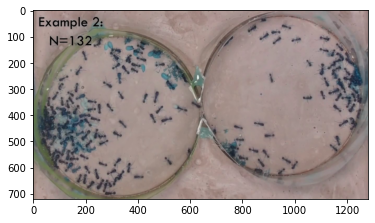

In [21]:
vid = cv2.VideoCapture('./videos/Ant Tracking Hard.mp4')

while vid.isOpened() :
    ret, frame = vid.read()
    
    if ret :
        cv2.imshow('Video frame', frame)

        if cv2.waitKey(int(1000/24)) & 0xFF == ord('q') : # this line control the period between image frame
            break
    else :
        break
    plt.imshow(frame)
vid.release()
plt.show()
cv2.destroyAllWindows()

<h1 style="text-align: center">
    Lucus-Kanade Sparse Optical Flow 
</h1> <br>
<h2 style="text-align: left">
    <a href="https://docs.opencv.org/4.5.3/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323"> calcOpticalFlowPyrLK()</a>
    is a Lucas-Kanade Spares Optical Flow built-in OpenCV function inside 
    <a href="https://docs.opencv.org/4.5.3/dc/d6b/group__video__track.html"> Object Tracking </a>
    module.
</h2>

In [4]:
def lucas_kanade_optical_flow(video_device) :

    cap = cv2.VideoCapture(video_device)
    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = 500,
                        qualityLevel = 0.03,
                        minDistance = 7,
                        blockSize = 25 )

    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (21,21),
                    maxLevel = 3,
                    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    #Create some random colors
    colors = np.random.randint(0, 255, (500, 3)) # 500 values 3 channel

    #Take first frame and find corner
    ret, old_frame = cap.read()
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params) # Feature detection, Harris corner with Shi-Tomasi response function

    # Create a mask image for drawing overlay
    mask = np.zeros_like(old_frame)

    while cap.isOpened() :
        
        ret, frame = cap.read()

        if ret :
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            #calculate optical flow 
            p1, st, err = cv2.calcOpticalFlowPyrLK(
                old_gray, frame_gray, p0, None, **lk_params
            )

            # Select good points
            good_new = p1[st == 1]
            good_old = p0[st == 1]

            # Traceline drawing
            for i, (new, old) in enumerate(zip(good_new, good_old)):
                a, b = new.ravel().astype(int)
                c, d = old.ravel().astype(int)
                mask = cv2.line(mask, (a, b), (c, d), colors[i].tolist(), 2)
                frame = cv2.circle(frame, (a,b), 5, colors[i].tolist(), -1)
            
            compare_img = cv2.hconcat([frame, mask])
            disp_img = cv2.add(frame, mask)
            cv2.imshow('compare', compare_img)
            cv2.imshow('frame', disp_img)

            key = cv2.waitKey(27) & 0xFF
            if key == 27 or key == ord('q') :
                break
            elif key == ord('c') : # clear mask
                mask = np.zeros_like(old_frame)
                p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
            else :
                #Update the previous frame and previous points
                old_gray = frame_gray.copy()
                p0 = good_new.reshape(-1, 1, 2)
        else :
            break

    cap.release()
    cv2.destroyAllWindows()

lucas_kanade_optical_flow(0)

<h1 style="text-align: center">
    Farnebäck Optical Flow
</h1> <br>
<h2 style="text-align: left">
    <a href="https://docs.opencv.org/4.5.3/dc/d6b/group__video__track.html#ga5d10ebbd59fe09c5f650289ec0ece5af"> calcOpticalFlowFarneback()</a>
    is a Farnebäck Dense Optical Flow built-in OpenCV function inside 
    <a href="https://docs.opencv.org/4.5.3/dc/d6b/group__video__track.html"> Object Tracking </a>
    module. <br>
    <a href="https://docs.opencv.org/4.5.3/d2/de8/group__core__array.html#gac5f92f48ec32cacf5275969c33ee837d">cartToPolar() </a>
    is a utility function for cartesian to polar conversion
</h2>

In [6]:
def farneback_dense_optical_flow(video_device) :
    cap = cv2.VideoCapture(video_device)

    ret, frame = cap.read()
    last_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    hsv = np.zeros_like(frame)
    hsv[:, :, 1] = 255

    while cap.isOpened() :
        ret, frame = cap.read()

        if ret :
            
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            flow = cv2.calcOpticalFlowFarneback(last_frame, frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0) # flow dx dy
            
            mag, ang = cv2.cartToPolar(flow[:, :, 0], flow[:, :, 1])
            hsv[:, :, 0] = ang*(180/np.pi/2)
            hsv[:, :, 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)

            flow_rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

            # thresh = cv2.inRange(hsv,(0, 0, 30), (20,255,255))
            # motion_segment = cv2.bitwise_and(frame, frame, mask=thresh )
            # cv2.imshow('thresh', motion_segment)
           
            last_frame = frame_gray.copy()

            cv2.imshow('frame', frame)
            cv2.imshow('flow', flow_rgb)
            key = cv2.waitKey(27) & 0xFF
            if key == 27 or key == ord('q') :
                break

        else :
            break
    
    cap.release()
    cv2.destroyAllWindows()
            

farneback_dense_optical_flow('./videos/Flow Visualization.mp4')

<h1 style="text-align: center">
    Optical Flow exercise
</h1>

<h2>แบบฝึกหัดที่ 10</h2>
<h4>วัตถุประสงค์ </h1>

- ทักษะการประยุกต์ใช้เทคนิค optical flow
<h4>โจทย์</h4>

- ให้นักศึกษาเขียน code ซอฟต์แวร์นำข้อมูลวิดีโอมาประมวลผลเพื่อติดตามการเคลื่อนไหวของคนหรือสิ่งของภายในภาพ (Crowd heatmapping)
- ให้นักศึกษากำหนด ROI (พื้นที่ที่สนใจของภาพ, พื้นที่ในกรอบสี่เหลี่ยมของภาพ) เพื่อป้องกันการตรวจจับเสาและสภาพแวดล้อมที่ไม่เกี่ยวข้องภายนอก
- ในการส่งงานให้นักศึกษาคอมเมนต์ code ที่ตนเองเขียนและอัพโหลดไปยัง github ของตนเองแล้วนำลิงก์ดังกล่าวไปโพสต์ส่งใน googleclassroom
- video ต่าง ๆ ที่ถูกในในตัวอย่างด้านบนอยู่ภายใน directory <a href="https://github.com/jbinteam/010723305/tree/main/videos">videos</a>
- ชุดข้อมูลวิดีโอ <a href = "https://github.com/jbinteam/010723305/blob/main/videos/grandcentral.mp4?raw=true">grandcentral.mp4</a><br>
- ผลลัพธ์ที่คาดหวัง <a href ="https://youtu.be/UoXAaafHeQY" >Youtube Video</a> 


In [5]:
## coding here :D
def lucas_kanade_optical_flow(video_device) :
    
    cap = cv2.VideoCapture(video_device)
    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = 500,
                        qualityLevel = 0.03,
                        minDistance = 7,
                        blockSize = 25 )

    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (21,21),
                    maxLevel = 3,
                    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    #Create some random colors
    colors = np.random.randint(0, 255, (500, 3)) # 500 values 3 channel

    #Take first frame and find corner
    ret, old_frame = cap.read()
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params) # Feature detection, Harris corner with Shi-Tomasi response function
    #print(old_frame.shape)
    # Create a mask image for drawing overlay
    mask = np.zeros_like(old_frame)
    pts = np.array([[180,30],[30,479],[720,479],[560,30]],np.int32) #กำหนดตำแหน่งของพื้นที่ ที่ต้องการหา
    roi = np.zeros(old_frame.shape[:2],np.uint8) #สร้าง mask ให้มีขนาดเท่า frame video
    cv2.drawContours(roi,[pts],-1,(255,255,255),-1,cv2.LINE_AA) #วาดกรอบ contours ตามตำแหน่งของพื้นที่ ที่กำหนดให้เป็นสีขาว
    #cv2.imshow('mask',roi)

    while cap.isOpened() :
        
        ret, frame = cap.read()

        if ret :
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            #calculate optical flow 
            p1, st, err = cv2.calcOpticalFlowPyrLK(
                old_gray, frame_gray, p0, None, **lk_params
            )

            # Select good points
            good_new = p1[st == 1]
            good_old = p0[st == 1]

            # Traceline drawing
            for i, (new, old) in enumerate(zip(good_new, good_old)):
                a, b = new.ravel().astype(int)
                c, d = old.ravel().astype(int)
                if b >= roi.shape[0]: #ถ้าค่าของ b มากกว่าหรือเท่ากับ 480 
                    b = roi.shape[0]-1  #ให้ b เท่ากับ (480-1) เท่ากับ 479 
                if a >= roi.shape[1]: #ถ้าค่าของ a มากกว่าหรือเท่ากับ 720
                    a = roi.shape[1]-1 #ให้ a เท่ากับ (720-1) เท่ากับ 719 
                if roi[b,a] ==255: #ถ้า b และ a เท่ากับ 255 หรือสีขาว ให้ทำตามคำสั่งด้านล่าง
                    mask = cv2.line(mask, (a, b), (c, d), (255,0,0), 2) #มาร์คตำแหน่งทางเดิน
                    frame = cv2.circle(frame, (a,b), 5, (0,255,0), 1)   #มาร์คตำแหน่งคน
                
            compare_img = cv2.hconcat([frame, mask])
            disp_img = cv2.add(frame, mask)
            cv2.drawContours(disp_img,[pts],-1,(0,150,255),1,cv2.LINE_AA) #วาดเส้นกรอบ contours ตามตำแหน่งของพื้นที่ ที่กำหนด
            cv2.imshow('compare', compare_img)
            cv2.imshow('frame', disp_img)
            #cv2.imshow('mask', pts)
            print(len(good_old))
            key = cv2.waitKey(27) & 0xFF
            if key == 27 or key == ord('q') :
                break
            elif len(good_old) < 485 : # clear mask
                #mask = np.zeros_like(old_frame)
                p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
            else :
                #Update the previous frame and previous points
                old_gray = frame_gray.copy()
                p0 = good_new.reshape(-1, 1, 2)
        else :
            break
        #plt.imshow(frame)

    cap.release()
    #plt.show()
    cv2.destroyAllWindows()
    

lucas_kanade_optical_flow('./videos/grandcentral.mp4')

500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
498
498
497
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
495
493
493
493
491
490
490
490
490
490
490
490
490
490
490
490
490
490
490
490
490
490
490
490
490
490
490
489
489
489
489
489
489
489
489
489
